In [37]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import compute_class_weight
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras import layers, models

In [38]:
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [39]:
def load_images_from_folder(folder_path, img_size=(224, 224), max_images=500):
    """
    Loads images from a folder, preprocesses them:
    - Resizes to specified dimensions
    - Normalizes pixel values to [0, 1]

    Skips invalid or unreadable files.

    :param max_images: int, maximum number of images to load
    :param folder_path: str Path to the folder containing images
    :param img_size: tuple Target size for resizing (width, height)
    :return: np.array, Array of preprocessed images with shape (num_samples, img_size[0], img_size[1])
    """
    processed = []

    if not os.path.exists(folder_path):
        print(f"⚠️ Folder does not exist: {folder_path}")
        return np.array(processed)
    print(f"<UNK> Processing images in folder: {folder_path}")
    print(len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]))

    for filename in os.listdir(folder_path):
        if max_images == 0:
            break
        max_images-=1
        img_path = os.path.join(folder_path, filename)

        # Load image
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Failed to load image: {img_path}")
            continue

        try:
            # Resize image
            resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

            # Normalize pixel values to [0, 1]
            normalized = resized.astype('float32') / 255.0

            # Add to list
            processed.append(normalized)

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            continue

    return np.array(processed)

In [40]:
def combine_arrays(*arrays):
    """
    Combines arrays into a single array

    :param arrays:
    :return:
    """
    return np.concatenate([arr for arr in arrays if len(arr) > 0])

In [41]:
def restructure_class_datasets(class_arrays_dict, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Takes a dictionary of {class_name: array_of_images}, combines train+valid,
    then splits into new train/val/test sets.

    :param class_arrays_dict: dict, Dictionary mapping class names to arrays of images
    :param train_ratio: float, Ratio of train set size
    :param val_ratio: float, Ratio of validation set size
    :param test_ratio: float, Ratio of test set size
    :return X_train, y_train, X_val, y_val, X_test, y_test
    """
    assert round(train_ratio + val_ratio + test_ratio) == 1, "Ratios must sum to 1"

    all_X = []
    all_y = []

    class_names = list(class_arrays_dict.keys())
    for idx, cls_name in enumerate(class_names):
        images = class_arrays_dict[cls_name]
        labels = [idx] * len(images)

        all_X.append(images)
        all_y.extend(labels)

    all_X = np.vstack(all_X)
    all_y = np.array(all_y)

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_X, all_y, test_size=(val_ratio + test_ratio), random_state=42
    )

    val_test_ratio = test_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_test_ratio, random_state=42
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names

In [42]:
def preprocess_dataset(base_dir: str='merge', img_size=(224, 224), max_images=500):
    images = {}

    # Loop through each directory and load images
    for folder in os.listdir(base_dir):
        imags = load_images_from_folder(f"{base_dir}/{folder}", img_size=img_size, max_images=max_images)
        images[folder] = imags

    del imags

    generalized_datasets = {}

    GENERALIZED_CLASSES = {
        0 : [
            images['Apple__black_rot'],
            images['Grape__black_rot'],
            images['Corn__common_rust'],
            images['Corn__gray_leaf_spot'],
            images['Corn__northern_leaf_blight'],
            images['Cherry__powdery_mildew'],
            images['Chili__leaf spot'],
            images['Coffee__cercospora_leaf_spot'],
            images['Coffee__rust'],
            images['Cucumber__diseased'],
            images['Grape__leaf_blight_(isariopsis_leaf_spot)'],
            images['Strawberry___leaf_scorch'],
            images['Tea__algal_leaf'],
            images['Tea__anthracnose'],
            images['Tea__bird_eye_spot'],
            images['Tea__brown_blight'],
            images['Tea__red_leaf_spot'],
            images['Tomato__early_blight'],
            images['Tomato__late_blight'],
            images['Tomato__leaf_mold'],
            images['Tomato__septoria_leaf_spot'],
            images['Tomato__target_spot'],
            images['Wheat__brown_rust'],
            images['Wheat__yellow_rust'],
            images['Wheat__septoria']
        ],
        1: [
            images['Apple__scab'],
            images['Cassava__bacterial_blight'],
            images['Chili__leaf curl'],
            images['Chili__whitefly'],
            images['Peach__bacterial_spot'],
            images['Pepper_bell__bacterial_spot'],
            images['Potato__early_blight'],
            images['Potato__late_blight'],
            images['Sugarcane__bacterial_blight'],
            images['Tomato__bacterial_spot'],
            images['Soybean__bacterial_blight']
        ],
        2: [
            images['Chili__yellowish'],
            images['Jamun__diseased'],
            images['Lemon__diseased'],
            images['Mango__diseased'],
            images['Pomegranate__diseased'],
            images['Tomato__mosaic_virus'],
            images['Tomato__yellow_leaf_curl_virus'],
            images['Soybean__mosaic_virus']
        ],
        3: [
            images['Apple__rust'],
            images['Cassava__mosaic_disease'],
            images['Rice__hispa'],
            images['Soybean__caterpillar'],
            images['Soybean__diabrotica_speciosa'],
            images['Coffee__red_spider_mite'],
            images['Tomato__spider_mites_(two_spotted_spider_mite)']
        ],
        4: [
            images['Cassava__brown_streak_disease'],
            images['Cassava__green_mottle'],
            images['Gauva__diseased'],
            images['Grape__black_measles'],
            images['Rice__leaf_blast'],
            images['Rice__neck_blast'],
            images['Soybean__southern_blight'],
            images['Sugarcane__red_rot'],
            images['Sugarcane__red_stripe'],
            images['Sugarcane__rust']
        ],
        5: [
            images['Apple__healthy'],
            images['Cassava__healthy'],
            images['Cherry__healthy'],
            images['Chili__healthy'],
            images['Coffee__healthy'],
            images['Corn__healthy'],
            images['Cucumber__healthy'],
            images['Gauva__healthy'],
            images['Grape__healthy'],
            images['Jamun__healthy'],
            images['Lemon__healthy'],
            images['Mango__healthy'],
            images['Peach__healthy'],
            images['Pepper_bell__healthy'],
            images['Pomegranate__healthy'],
            images['Potato__healthy'],
            images['Rice__healthy'],
            images['Soybean__healthy'],
            images['Strawberry__healthy'],
            images['Sugarcane__healthy'],
            images['Tea__healthy'],
            images['Tomato__healthy'],
            images['Wheat__healthy']
        ]
    }

    for disease, array_list in GENERALIZED_CLASSES.items():
        try:
            combined = combine_arrays(*array_list)
            generalized_datasets[disease] = combined
            print(f"{disease}: {combined.shape}")
        except Exception as e:
            print(f"Error combining {disease}: {e}")

    del images
    del GENERALIZED_CLASSES

    (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = restructure_class_datasets(generalized_datasets)

    del generalized_datasets

    x_shuffle = np.random.permutation(len(X_train))
    X_train = X_train[x_shuffle]
    y_train = y_train[x_shuffle]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [43]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=128, epochs=100, callbacks=None, shuffle=True, class_weights=None):

    if callbacks is None:
        callbacks = []
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[callbacks],
        class_weight=class_weights,
        shuffle=shuffle,
        verbose=2
    )

    return history

In [44]:
def plot_history(history):
    # Plot the loss curves
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Plot the accuracy curves
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()


In [45]:
def plot_confussion_matrix(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    print("Confusion Matrix")
    print(cm)

In [46]:
INPUT_SHAPE = (48, 48, 3)
OUTPUT_SIZE = 6
BATCH_SIZE = 128
EPOCHS = 100
MAX_IMAGES=500

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global average pooling instead of Flatten()
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,182 (1.50 MB)

 Trainable params: 393,414 (1.50 MB)

 Non-trainable params: 768 (3.00 KB)

In [48]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset(base_dir='merge', img_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]), max_images=MAX_IMAGES)

<UNK> Processing images in folder: merge/Apple__black_rot
621
<UNK> Processing images in folder: merge/Apple__healthy
1649
<UNK> Processing images in folder: merge/Apple__rust
357
<UNK> Processing images in folder: merge/Apple__scab
700
<UNK> Processing images in folder: merge/Cassava__bacterial_blight
486
<UNK> Processing images in folder: merge/Cassava__brown_streak_disease
558
<UNK> Processing images in folder: merge/Cassava__green_mottle
471
<UNK> Processing images in folder: merge/Cassava__healthy
677
<UNK> Processing images in folder: merge/Cassava__mosaic_disease
444
<UNK> Processing images in folder: merge/Cherry__healthy
906
<UNK> Processing images in folder: merge/Cherry__powdery_mildew
1052
<UNK> Processing images in folder: merge/Chili__healthy
100
<UNK> Processing images in folder: merge/Chili__leaf curl
100
<UNK> Processing images in folder: merge/Chili__leaf spot
100
<UNK> Processing images in folder: merge/Chili__whitefly
100
<UNK> Processing images in folder: merge/Chi

Epoch 1/100
167/167 - 96s - 576ms/step - accuracy: 0.5422 - loss: 1.1451 - val_accuracy: 0.2716 - val_loss: 2.5953
Epoch 2/100
167/167 - 94s - 565ms/step - accuracy: 0.6439 - loss: 0.8920 - val_accuracy: 0.2758 - val_loss: 4.3433
Epoch 3/100
167/167 - 100s - 599ms/step - accuracy: 0.7173 - loss: 0.7195 - val_accuracy: 0.3093 - val_loss: 2.8239
Epoch 4/100
167/167 - 98s - 590ms/step - accuracy: 0.7644 - loss: 0.6071 - val_accuracy: 0.4371 - val_loss: 2.4965
Epoch 5/100
167/167 - 106s - 633ms/step - accuracy: 0.7919 - loss: 0.5356 - val_accuracy: 0.6815 - val_loss: 0.8121
Epoch 6/100
167/167 - 134s - 801ms/step - accuracy: 0.8160 - loss: 0.4725 - val_accuracy: 0.7793 - val_loss: 0.5829
Epoch 7/100
167/167 - 134s - 802ms/step - accuracy: 0.8344 - loss: 0.4177 - val_accuracy: 0.7148 - val_loss: 0.7544
Epoch 8/100
167/167 - 134s - 802ms/step - accuracy: 0.8478 - loss: 0.3888 - val_accuracy: 0.6173 - val_loss: 1.1837
Epoch 9/100
167/167 - 134s - 801ms/step - accuracy: 0.8624 - loss: 0.3539 -

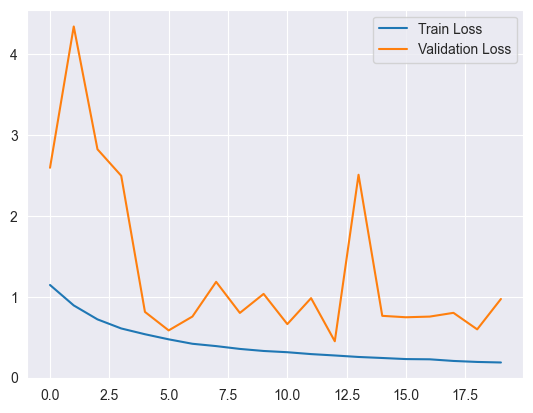

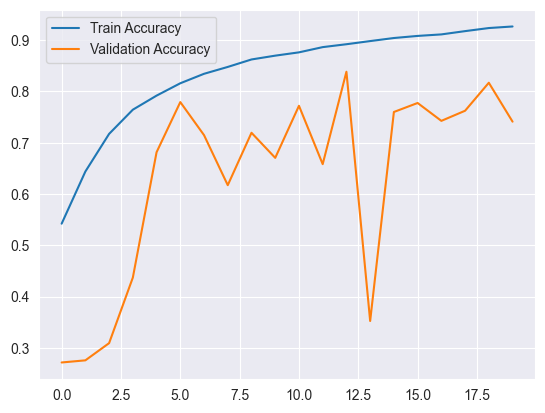

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

history = train_model(model, X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping])

plot_history(history)

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8553 - loss: 0.4299
Test Loss: 0.4468326270580292
Test Accuracy: 0.8472496271133423
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step


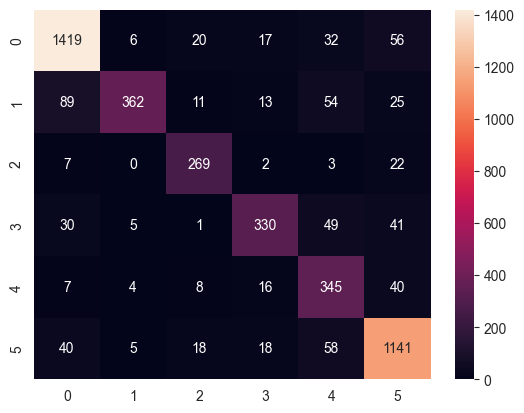

Confusion Matrix
[[1419    6   20   17   32   56]
 [  89  362   11   13   54   25]
 [   7    0  269    2    3   22]
 [  30    5    1  330   49   41]
 [   7    4    8   16  345   40]
 [  40    5   18   18   58 1141]]


In [50]:
plot_confussion_matrix(model, X_test, y_test)

In [51]:
model.save(f"{BATCH_SIZE}_custom_{MAX_IMAGES}_{INPUT_SHAPE[0]}.keras")

In [52]:
INPUT_SHAPE = (224, 224, 3)
OUTPUT_SIZE = 6
BATCH_SIZE = 128
EPOCHS = 100
MAX_IMAGES=100

In [53]:
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)

# Global pooling and dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(OUTPUT_SIZE, activation='softmax')(x)

# Final model
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,980,294 (11.37 MB)

 Trainable params: 722,310 (2.76 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [54]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset(base_dir='merge', img_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]), max_images=MAX_IMAGES)

<UNK> Processing images in folder: merge/Apple__black_rot
621
<UNK> Processing images in folder: merge/Apple__healthy
1649
<UNK> Processing images in folder: merge/Apple__rust
357
<UNK> Processing images in folder: merge/Apple__scab
700
<UNK> Processing images in folder: merge/Cassava__bacterial_blight
486
<UNK> Processing images in folder: merge/Cassava__brown_streak_disease
558
<UNK> Processing images in folder: merge/Cassava__green_mottle
471
<UNK> Processing images in folder: merge/Cassava__healthy
677
<UNK> Processing images in folder: merge/Cassava__mosaic_disease
444
<UNK> Processing images in folder: merge/Cherry__healthy
906
<UNK> Processing images in folder: merge/Cherry__powdery_mildew
1052
<UNK> Processing images in folder: merge/Chili__healthy
100
<UNK> Processing images in folder: merge/Chili__leaf curl
100
<UNK> Processing images in folder: merge/Chili__leaf spot
100
<UNK> Processing images in folder: merge/Chili__whitefly
100
<UNK> Processing images in folder: merge/Chi

Epoch 1/100
45/45 - 50s - 1s/step - accuracy: 0.6127 - loss: 1.0404 - val_accuracy: 0.7403 - val_loss: 0.6845
Epoch 2/100
45/45 - 46s - 1s/step - accuracy: 0.7750 - loss: 0.5992 - val_accuracy: 0.8028 - val_loss: 0.5375
Epoch 3/100
45/45 - 46s - 1s/step - accuracy: 0.8336 - loss: 0.4476 - val_accuracy: 0.7938 - val_loss: 0.5616
Epoch 4/100
45/45 - 46s - 1s/step - accuracy: 0.8690 - loss: 0.3567 - val_accuracy: 0.8324 - val_loss: 0.4726
Epoch 5/100
45/45 - 46s - 1s/step - accuracy: 0.9025 - loss: 0.2743 - val_accuracy: 0.8291 - val_loss: 0.4753
Epoch 6/100
45/45 - 46s - 1s/step - accuracy: 0.9118 - loss: 0.2356 - val_accuracy: 0.8332 - val_loss: 0.4623
Epoch 7/100
45/45 - 46s - 1s/step - accuracy: 0.9305 - loss: 0.1923 - val_accuracy: 0.8398 - val_loss: 0.4497
Epoch 8/100
45/45 - 46s - 1s/step - accuracy: 0.9327 - loss: 0.1832 - val_accuracy: 0.8250 - val_loss: 0.4989
Epoch 9/100
45/45 - 46s - 1s/step - accuracy: 0.9482 - loss: 0.1439 - val_accuracy: 0.8562 - val_loss: 0.4310
Epoch 10/1

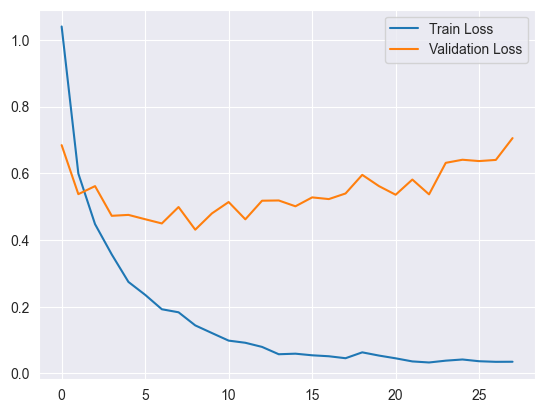

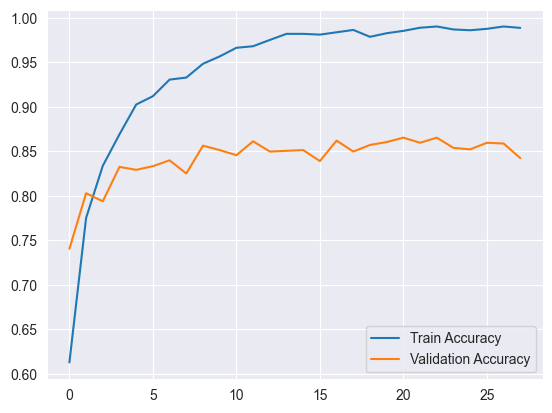

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

history = train_model(model, X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping])

plot_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8606 - loss: 0.5523
Test Loss: 0.5118456482887268
Test Accuracy: 0.8645319938659668
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step


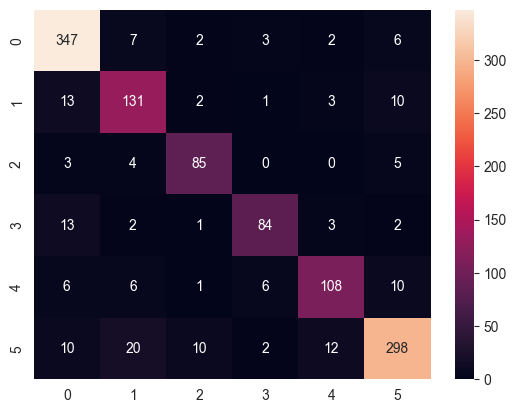

Confusion Matrix
[[347   7   2   3   2   6]
 [ 13 131   2   1   3  10]
 [  3   4  85   0   0   5]
 [ 13   2   1  84   3   2]
 [  6   6   1   6 108  10]
 [ 10  20  10   2  12 298]]


In [56]:
plot_confussion_matrix(model, X_test, y_test)

In [57]:
model.save(f"{BATCH_SIZE}_mobilenetv2_{MAX_IMAGES}_{INPUT_SHAPE[0]}.keras")

In [58]:
base_model = ResNet50V2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base layers initially
base_model.trainable = False

# Add custom head
inputs = layers.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)

# Global pooling + dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(OUTPUT_SIZE, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,680,326 (94.15 MB)

 Trainable params: 1,115,526 (4.26 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/100
45/45 - 116s - 3s/step - accuracy: 0.5586 - loss: 1.1684 - val_accuracy: 0.7083 - val_loss: 0.7738
Epoch 2/100
45/45 - 110s - 2s/step - accuracy: 0.7269 - loss: 0.7086 - val_accuracy: 0.7757 - val_loss: 0.6444
Epoch 3/100
45/45 - 111s - 2s/step - accuracy: 0.7989 - loss: 0.5421 - val_accuracy: 0.7707 - val_loss: 0.6528
Epoch 4/100
45/45 - 110s - 2s/step - accuracy: 0.8303 - loss: 0.4548 - val_accuracy: 0.7880 - val_loss: 0.5698
Epoch 5/100
45/45 - 112s - 2s/step - accuracy: 0.8500 - loss: 0.4046 - val_accuracy: 0.7946 - val_loss: 0.5684
Epoch 6/100
45/45 - 112s - 2s/step - accuracy: 0.8762 - loss: 0.3287 - val_accuracy: 0.8102 - val_loss: 0.5513
Epoch 7/100
45/45 - 111s - 2s/step - accuracy: 0.8954 - loss: 0.2775 - val_accuracy: 0.8020 - val_loss: 0.5640
Epoch 8/100
45/45 - 110s - 2s/step - accuracy: 0.9100 - loss: 0.2487 - val_accuracy: 0.8233 - val_loss: 0.5318
Epoch 9/100
45/45 - 110s - 2s/step - accuracy: 0.9195 - loss: 0.2207 - val_accuracy: 0.8159 - val_loss: 0.5401
E

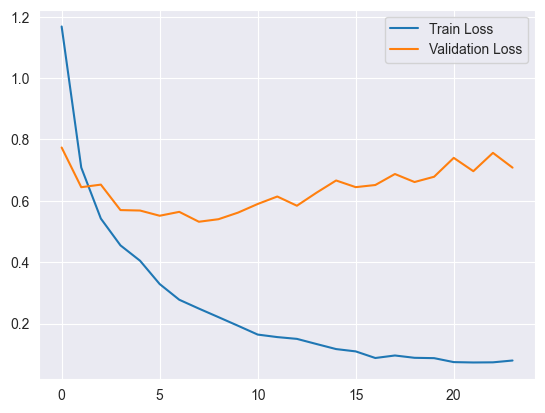

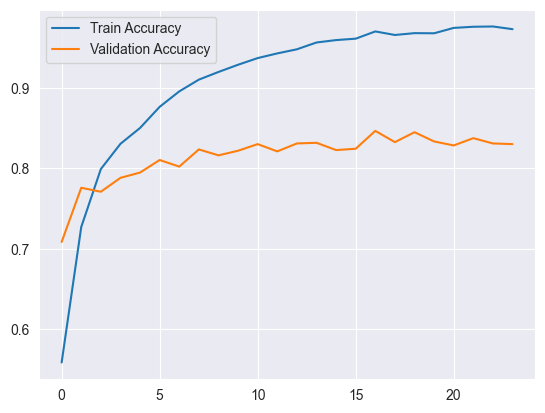

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

history = train_model(model, X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE, epochs=EPOCHS,
                      callbacks=[early_stopping])

plot_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step - accuracy: 0.8370 - loss: 0.7102
Test Loss: 0.6226212382316589
Test Accuracy: 0.8456485867500305
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step


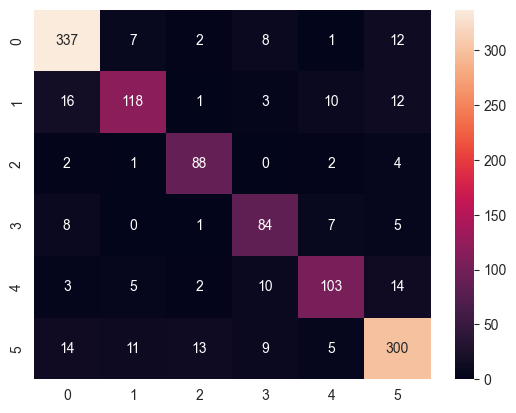

Confusion Matrix
[[337   7   2   8   1  12]
 [ 16 118   1   3  10  12]
 [  2   1  88   0   2   4]
 [  8   0   1  84   7   5]
 [  3   5   2  10 103  14]
 [ 14  11  13   9   5 300]]


In [60]:
plot_confussion_matrix(model, X_test, y_test)

In [61]:
model.save(f"{BATCH_SIZE}_resnetv50_{MAX_IMAGES}_{INPUT_SHAPE[0]}.keras")